# Predictive Survival Analysis

This type of analytics answer the question "what will happened?"

# Survival Regression


Whenever we have additional variables next to duration & event, we can use survival regression. 

## Taxonomy of Predictive Methods (Statistical) 


![image](_asset/taxonomy-predictive.jpg)

*Taxonomy of predictive statistical survival methods.  ML for Survival Analysis: A Survey [2018]*

Among the many methods available, Cox proportional hazard (CPH) and accelerated failure models are popular with many implementation. These methods model hazard rate $h(t, x)$, as a function of time $t$ and covariate $x$

## Cox Proportional Hazard (CHP) Model

Traditional models, e.g., line linear regression, can not be used due to censoring. CPH model is based on the idea that log of the hazard is a linear function of covariates
$$
\log \left [ \frac{h(t, x)}{h_0(t)} \right ] = \beta ^{\top} x  \, \Longrightarrow \,  h(t,x) = h_0(t) \, e^{\beta ^{\top} x}  
$$
where $x$ and $\beta$ are variable and regression coefficient vectors, respectively, and $h_0(t)$ is a base-line hazard function (semi-parametric & non-negative). 

Attention: The only time-varying component in CPH model is the base-line hazard $h_0(t)$, where individual covariates would only scale this function with the time-invariant factor $e^{\beta ^{\top} x}$ 

### Proportional Hazard Assumption

The Proportional Hazards assumption means that the hazard ratio of two sample is constant over time (time-invariant), 

$$
 \frac{h(t, x_1)}{h(t, x_2)} = \frac{h_0(t) \, e^{\beta ^{\top} x_1}}{h_0(t) \, e^{\beta ^{\top} x_2} } = e^{\beta ^{\top} (x_1 - x_2)} 
$$

In below figure, we see the survival function given different values of the covariate $x$ 

- All the survival curves are a scaling of the base-line hazard
- Given PH assumption, any two arbitrary survival curve has a time-invariant hazard rate 

![image](_asset/proportional-hazard-assumption.jpg)

*Survival function vs time, given different covariates. Courtesy of ifelines.readthedocs.io*



- Crossing of the survival/hazard curves for two or more categories of a predictor of interest, signal that the PH assumption is not met. However, it is possible that the functions do not cross and the PH assumption is not met. Thus, other approaches are needed to check PH assumption than curves crossing in a graph.

```{note}
Checking cox proportional hazard assumption is not important for predictive analytics, while 
the situation is different in prescriptive analytics. 

- In prediction the objective is to maximize an accuracy metric, and not to learn about how individual feature contribute to the model making that prediction.

- In prescriptive analytics, the focus is on inference & correlation and to understand the influence of individual variables on the survival duration & event.
```

### Fitting CPH

In [1]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

df = load_rossi()

cph = CoxPHFitter()
cph.fit(df, duration_col='week', event_col='arrest')

cph.print_summary()  

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-04-10 20:43:27 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

### Interpretation

- partial log-likelihood is the cost function

- breslow estimator is used to estimate $\hat H_0$. Then the baseline survival function can be calculated as $S_0(t) = e^{-H_0(t)}$

- Concordance will follow 

- 

Let's consider `fin` variable (whether subject provided with financial aid after release), a one unit increase in `fin` means the base-line hazard will decrease by $e^{-0.37} = 0.69$, why?

$$
 \frac{h(t | fin = 1)}{h(t | fin= 0)} = e^{\beta_{fin} (1- 0)} = e^{\beta_{fin}} = e^{-0.37} 
$$

Since the hazard ratio (vs base-line) is $0.69$ (< 1), we can argue financial aid reduces the risk of subjects getting re-arrested by 31%.

Along the same line of reasoning, whether the subject had prior arrest or not, i.e., `prio`, increase the risk of subjects getting re-arrested by 9%, with hazard ratio of $e^{0.09} = 1.09$


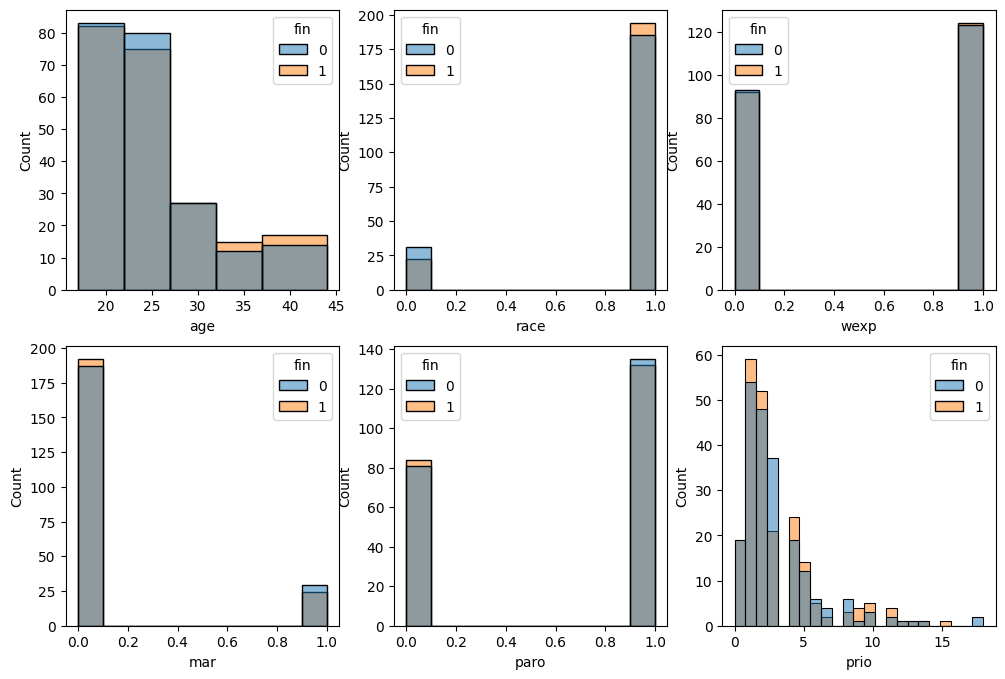

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
cols = df.columns.drop(['fin','week', 'arrest'])
axes = ax.ravel() 
for id, col in enumerate(cols):
    _ax = axes[id] 
    bins = [17, 22, 27, 32, 37, 44] if col == 'age' else 'auto'
    sns.histplot(data=df, x=col, hue='fin', alpha=0.5, bins=bins, ax=_ax)
    _ax.set_xlabel(col)

## Model Evaluataion 

If censoring is present, it’s not appropriate to use a loss function like mean-squared-error or mean-absolute-loss. This is because the difference between a censored value and the predicted value could be due to poor prediction or due to censoring. Below we introduce alternative ways to measure prediction performance.

Due to censoring metrics like Root Mean Square (RMS) and $R^2$ are not relevant to survival analysis. 

- Specialized evaluation metrics for survival are c-index, Brier score, and Mean Absolute Error (MAE),

### Concordance Index [C-index]

Definition of C-index: 

$$ C-index := \frac{\#  concordant \,\,\, pairs}{\# comparable \,\,\,  pairs} $$

- Concordant pair: the pair $(i, j)$ is concordant if $t_i > t_j$ and $\hat t_i > \hat t_j$ where $t$ is the observed time and $\hat t$ is the estimated survival time
- Comparable pairs: 

![imae](_asset/c-index.jpg)


# Prediction

-  on censored subjects

## Model Calibration

In [3]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
from lifelines.calibration import survival_probability_calibration

regression_dataset = load_rossi()
cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
cph.fit(rossi, "week", "arrest")

survival_probability_calibration(cph, rossi, t0=25);

NameError: name 'rossi' is not defined

## Predictions

In [ ]:
Prediction

# Checking Proportional Hazard Assumption Evaluation

It is important to note that if the graph of the hazards cross for two or more categories of a predictor of interest, the PH assumption is not met. However, althought the hazard functions do not cross, it is possible that the PH assumption is not met. Thus, rather than checking for crossing hazards, we need to use other apporaches.

In [ ]:
# It seems that the proportional hazards assumption is violated as the log-log survival curves are not parallel.

## Further Reading
parametric and non-parametric models

ML Models 
- Survival Trees
- Support Vector Machine
- Baysian Survival Analysis
- Deep Survival Analysis